## Import Libraries

In [227]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")
# set seed for reproductibility
np.random.seed(0)

## Loading the Data

In [228]:
# loading the data 
train = pd.read_csv("./train.csv")
test  = pd.read_csv( "./test.csv")

## Data Content

In [229]:
# lets start to look into train dataset
train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [230]:
train.shape

(8523, 12)

The train data set conatins 8523 rows and 12 columns

In [231]:
#check data and datatypes of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Weight and Outlet_Size column contains null values

In [232]:
#check the statistical information of the test dataset
train.describe(include= 'all')

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
count             8523  7060.000000             8523      8523.000000   
unique            1559          NaN                5              NaN   
top              FDW13          NaN          Low Fat              NaN   
freq                10          NaN             5089              NaN   
mean               NaN    12.857645              NaN         0.066132   
std                NaN     4.643456              NaN         0.051598   
min                NaN     4.555000              NaN         0.000000   
25%                NaN     8.773750              NaN         0.026989   
50%                NaN    12.600000              NaN         0.053931   
75%                NaN    16.850000              NaN         0.094585   
max                NaN    21.350000              NaN         0.328391   

                    Item_Type     Item_MRP Outlet_Identifier  \
count                    8523  8523.000000              8523   
unique                     16          NaN                10   
top     Fruits and Vegetables          NaN            OUT027   
freq                     1232          NaN               935   
mean                      NaN   140.992782               NaN   
std                       NaN    62.275067               NaN   
min                       NaN    31.290000               NaN   
25%                       NaN    93.826500               NaN   
50%                       NaN   143.012800               NaN   
75%                       NaN   185.643700               NaN   
max                       NaN   266.888400               NaN   

        Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
count                 8523.000000        6113                 8523   
unique                        NaN           3                    3   
top                           NaN      Medium               Tier 3   
freq                          NaN        2793                 3350   
mean                  1997.831867         NaN                  NaN   
std                      8.371760         NaN                  NaN   
min                   1985.000000         NaN                  NaN   
25%                   1987.000000         NaN                  NaN   
50%                   1999.000000         NaN                  NaN   
75%                   2004.000000         NaN                  NaN   
max                   2009.000000         NaN                  NaN   

              Outlet_Type  Item_Outlet_Sales  
count                8523        8523.000000  
unique                  4                NaN  
top     Supermarket Type1                NaN  
freq                 5577                NaN  
mean                  NaN        2181.288914  
std                   NaN        1706.499616  
min                   NaN          33.290000  
25%                   NaN         834.247400  
50%                   NaN        1794.331000  
75%                   NaN        3101.296400  
max                   NaN       13086.964800

- There are 1559 unique items
- 5 types of Item Fat Content
- 16 types of items with Fruits and Vegetables being the most frequently bought item
- 10 different outlets
- 3 outlet size types with Medium type being the most common one
- 3 types of outlet location wih Tier 3 being the most frequent one
- 3 types of outlet with Supermarket type 1 being the most common

In [233]:
#check for the number of nulls in each columns
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are null values in Item_Weight and Outlet_Size columns which we will need to impute

In [234]:
# lets investigate test dataset as well
test.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDW58       20.750          Low Fat         0.007565  Snack Foods   
1           FDW14        8.300              reg         0.038428        Dairy   
2           NCN55       14.600          Low Fat         0.099575       Others   
3           FDQ58        7.315          Low Fat         0.015388  Snack Foods   
4           FDY38          NaN          Regular         0.118599        Dairy   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  107.8622            OUT049                       1999      Medium   
1   87.3198            OUT017                       2007         NaN   
2  241.7538            OUT010                       1998         NaN   
3  155.0340            OUT017                       2007         NaN   
4  234.2300            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  
0               Tier 1  Supermarket Type1  
1               Tier 2  Supermarket Type1  
2               Tier 3      Grocery Store  
3               Tier 2  Supermarket Type1  
4               Tier 3  Supermarket Type3

In [235]:
test.shape

(5681, 11)

In [236]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [237]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

There are null values in the item_weight and Outlet_Size columns

## Exploratory Data Analysis

### Univarite analysis

#### Numerical Feature Analysis

In [238]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

##### Distribution plot of the numerical features

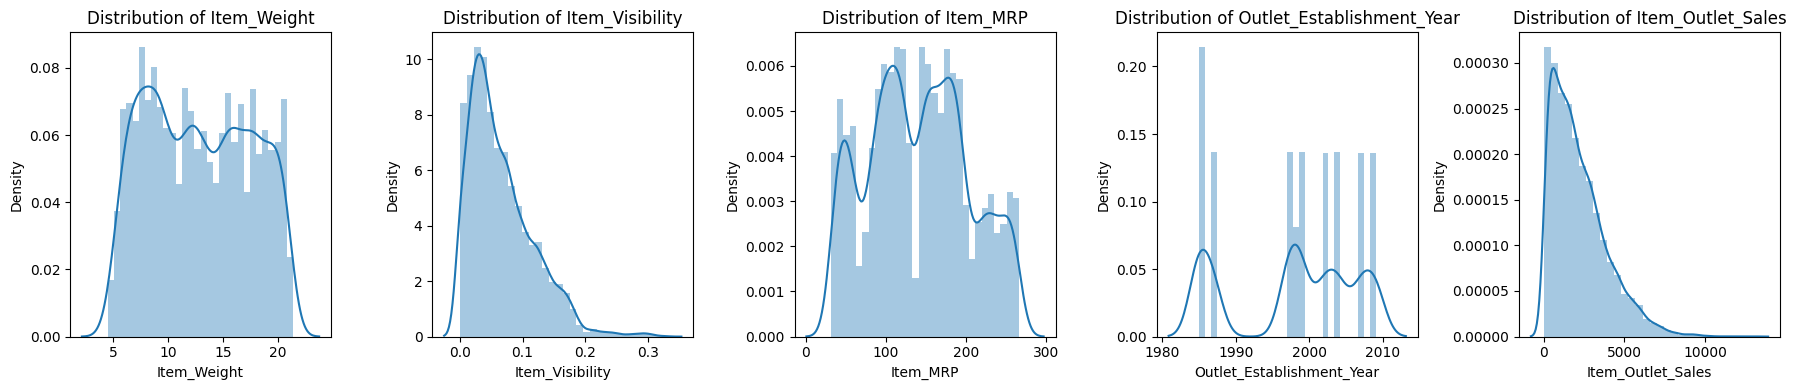

In [239]:
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(18, 4))
for ax, col in zip(axes, numeric_cols):
    sns.distplot(train[col].dropna(), ax=ax, bins=30, kde=True, hist=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

**Observation**
- The Item_Weight ranges from 5- 20 kg
- Item_Visibility has a right skewed distribution
- Most of the Item's MRP ranges from Rs 100 to 180
- Most of the outlets have been establised in the year of 1985, 1997 to 1999
- Item_Outlet_Sales is right skewed

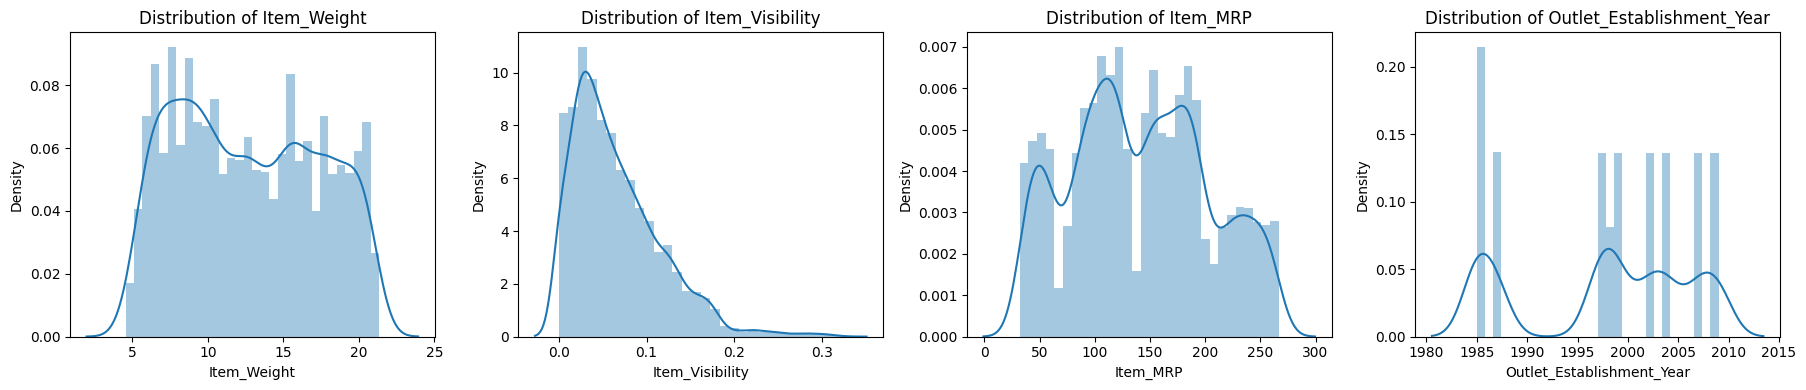

In [240]:
#plotting distribution for the test data
numeric_cols_test = test.select_dtypes(include=['float64', 'int64']).columns.tolist()
fig, axes = plt.subplots(1, len(numeric_cols_test), figsize=(18, 4))
for ax, col in zip(axes, numeric_cols_test):
    sns.distplot(test[col].dropna(), ax=ax, bins=30, kde=True, hist=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

##### Box Plot of the numerical Features

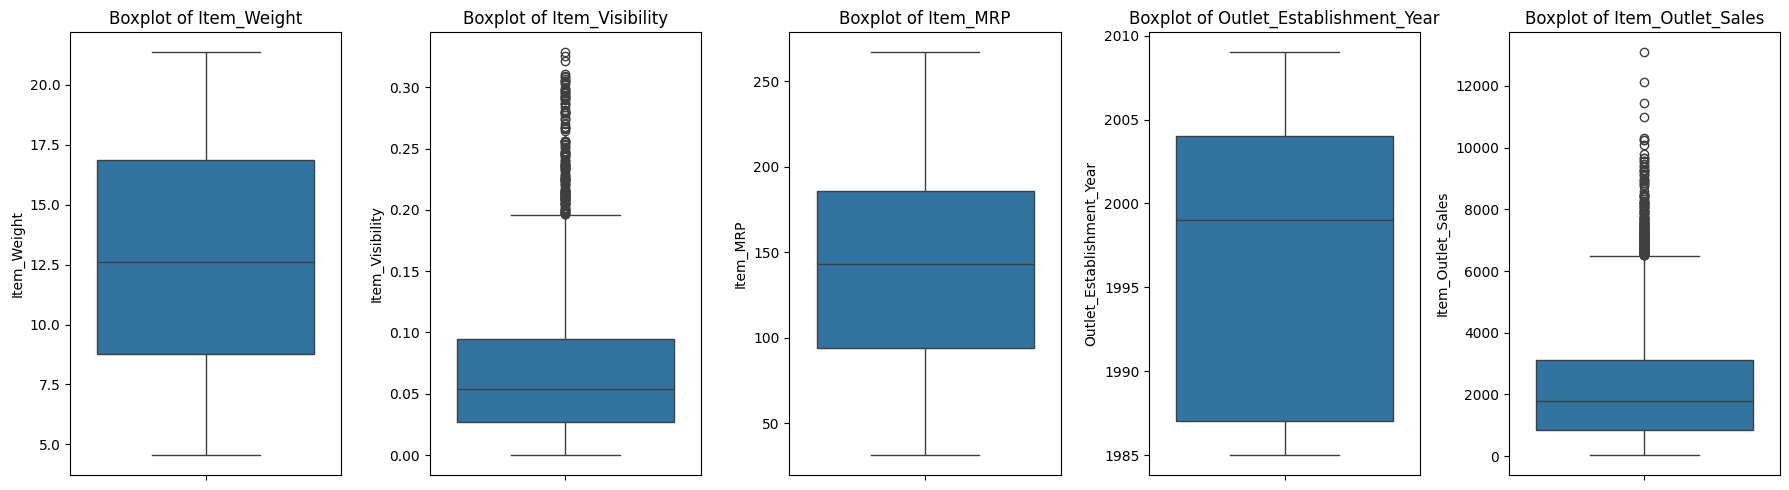

In [241]:
# Box plots for numerical features (side-by-side) of train data
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(18, 5))
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(y=train[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


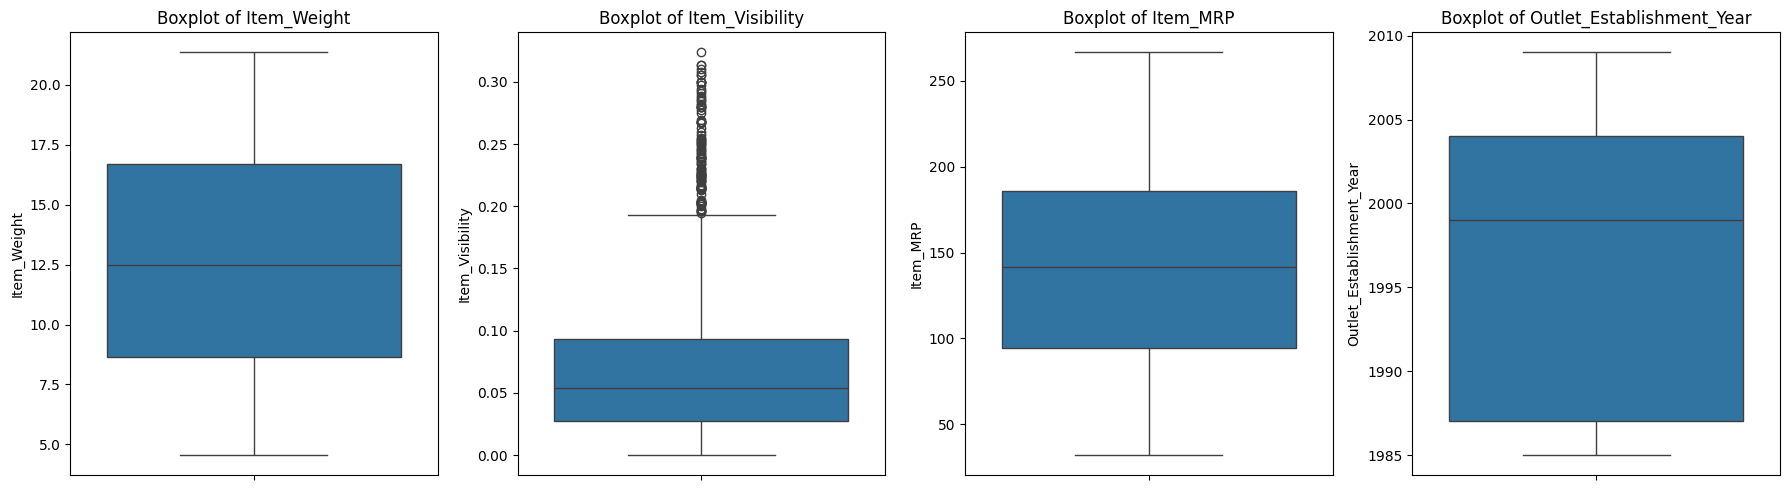

In [242]:
# Box plots for numerical features (side-by-side) of test data
fig, axes = plt.subplots(1, len(numeric_cols_test), figsize=(18, 5))
for ax, col in zip(axes, numeric_cols_test):
    sns.boxplot(y=test[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


**Observations:**
- Item_Weight, Item_MRP and OutletEstablishment_Year has no outliers
- Item_Visibility and Item_Outlet_Sales has outliers in the data
- the distribution of data both in test and train are almost similar

#### Categorical Features

In [243]:
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [244]:
#check how the categories of each of the categorical features look like
for col in categorical_features:
    print(f"\nValue counts for {col}:")
    print(train[col].value_counts())
    print("="*50)


Value counts for Item_Identifier:
Item_Identifier
FDW13    10
FDG33    10
NCF42     9
FDW26     9
FDX31     9
         ..
FDY43     1
FDO33     1
FDK57     1
FDQ60     1
FDN52     1
Name: count, Length: 1559, dtype: int64

Value counts for Item_Fat_Content:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Value counts for Item_Type:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Value counts for Outlet_Identifier:
Outlet_Identifier
OUT027    935
OUT0

##### Feature Distributions

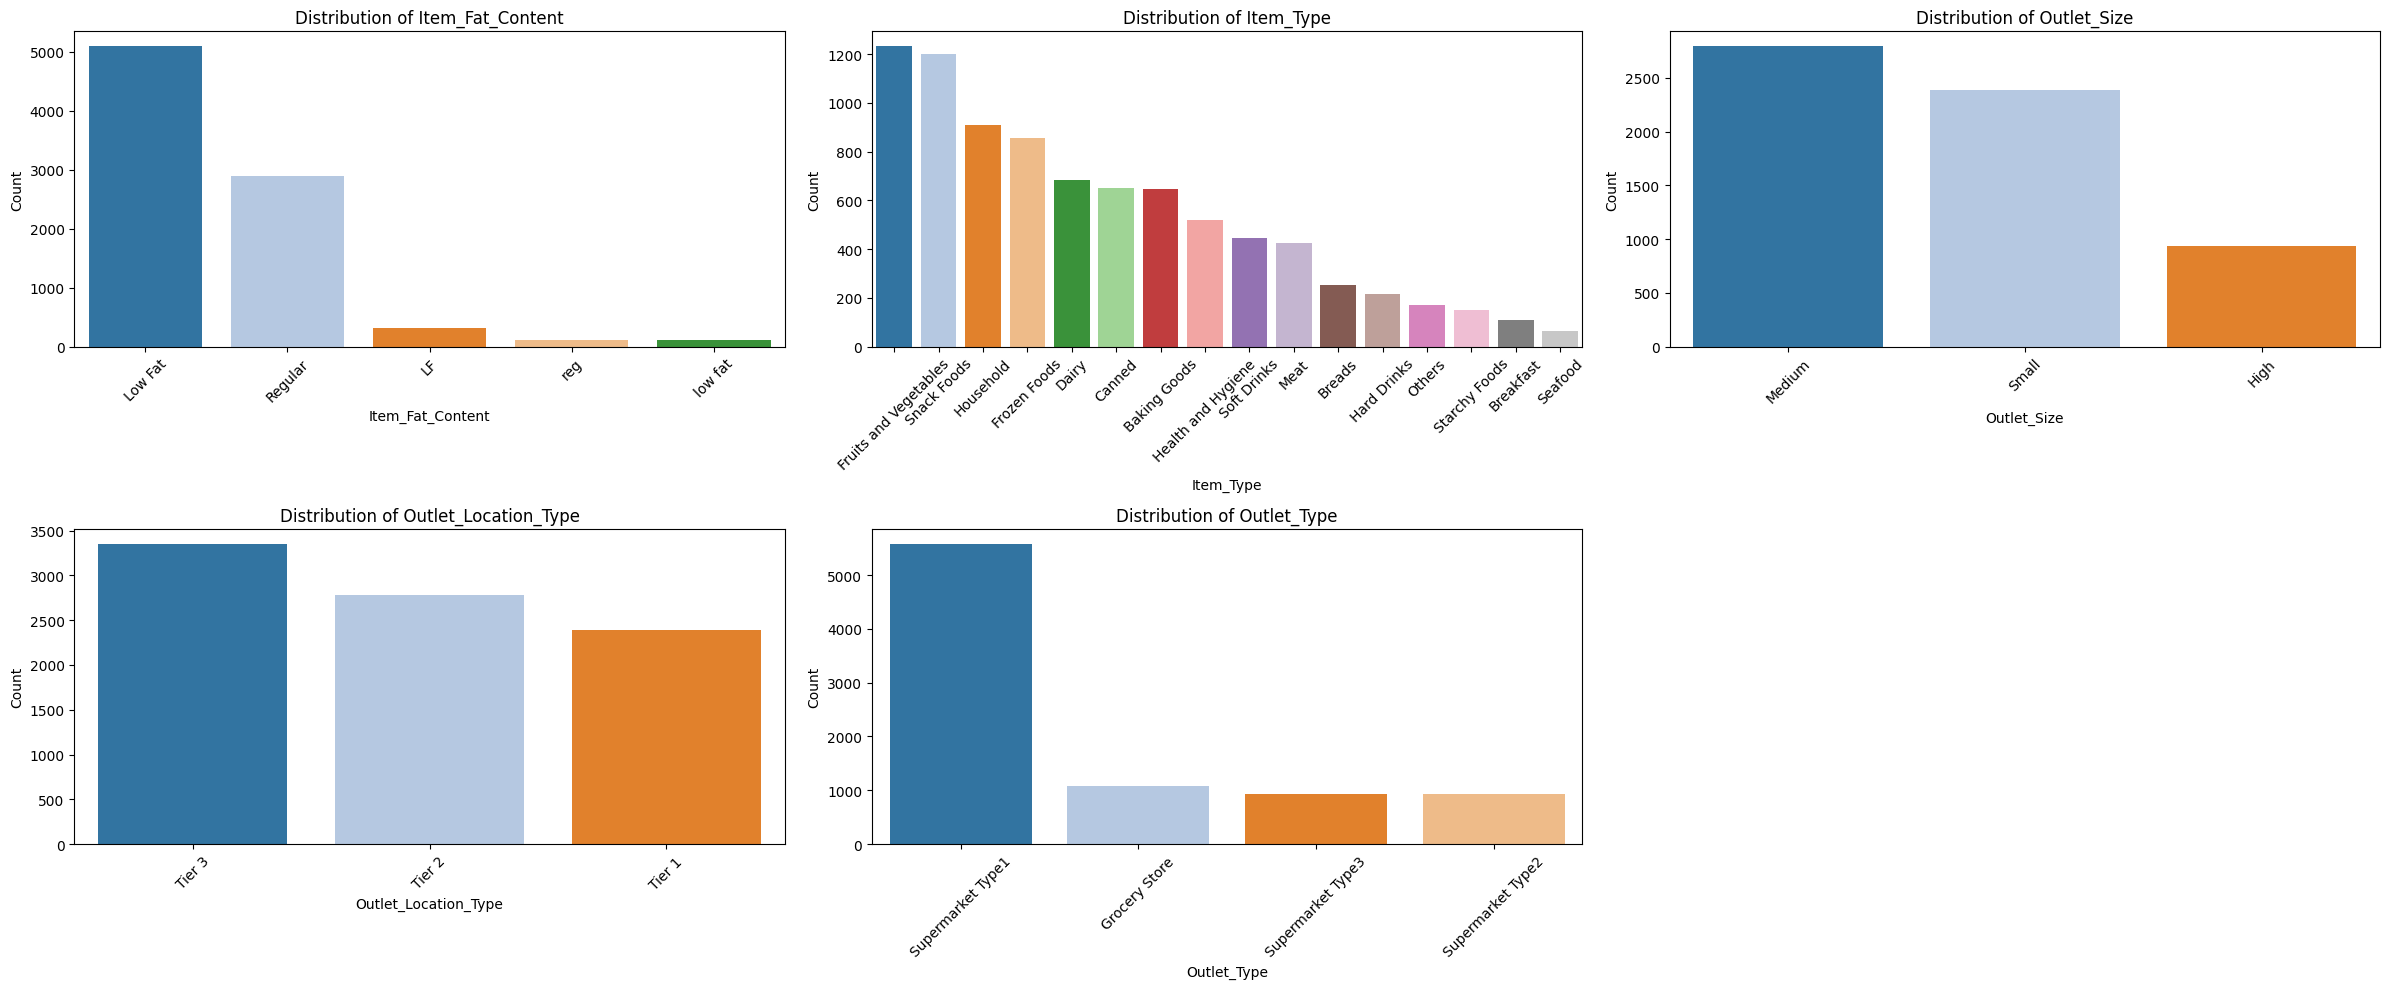

In [245]:
categorical_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']
# Set up the grid size dynamically based on number of features
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))
axes = axes.flatten()  # Flatten for easy indexing

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train, x=col, ax=axes[i], palette='tab20', order=train[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', labelrotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

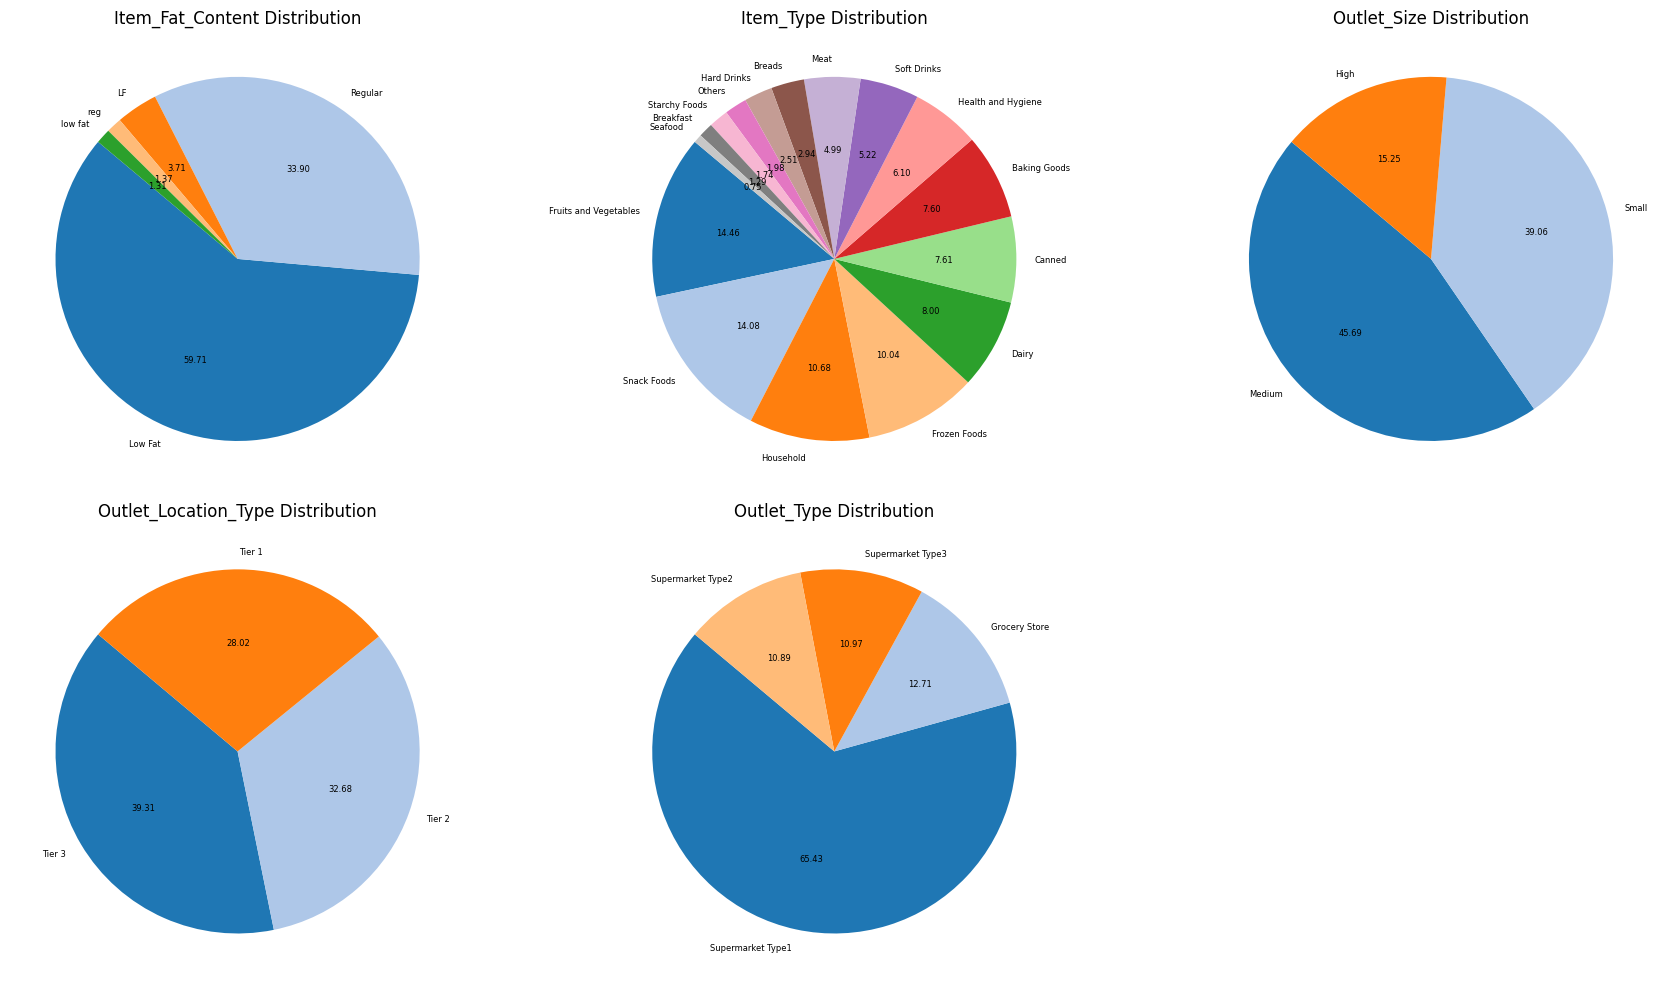

In [246]:
# Setup grid for side-by-side pie charts
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = train[col].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%.2f', startangle=140, colors=sns.color_palette('tab20', n_colors=len(counts)), textprops={'fontsize': 6})
    axes[i].set_title(f'{col} Distribution')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Observations:**
- Item_Fat_Content feature needs to be cleaned
  - LF, Low Fat and low fat should be made the same category "Low Fat"
  - reg and Regular should be mapped to same category "Regular"
- Outlet_Location_type can be encoded as per the tier number

### Bivariate Analysis

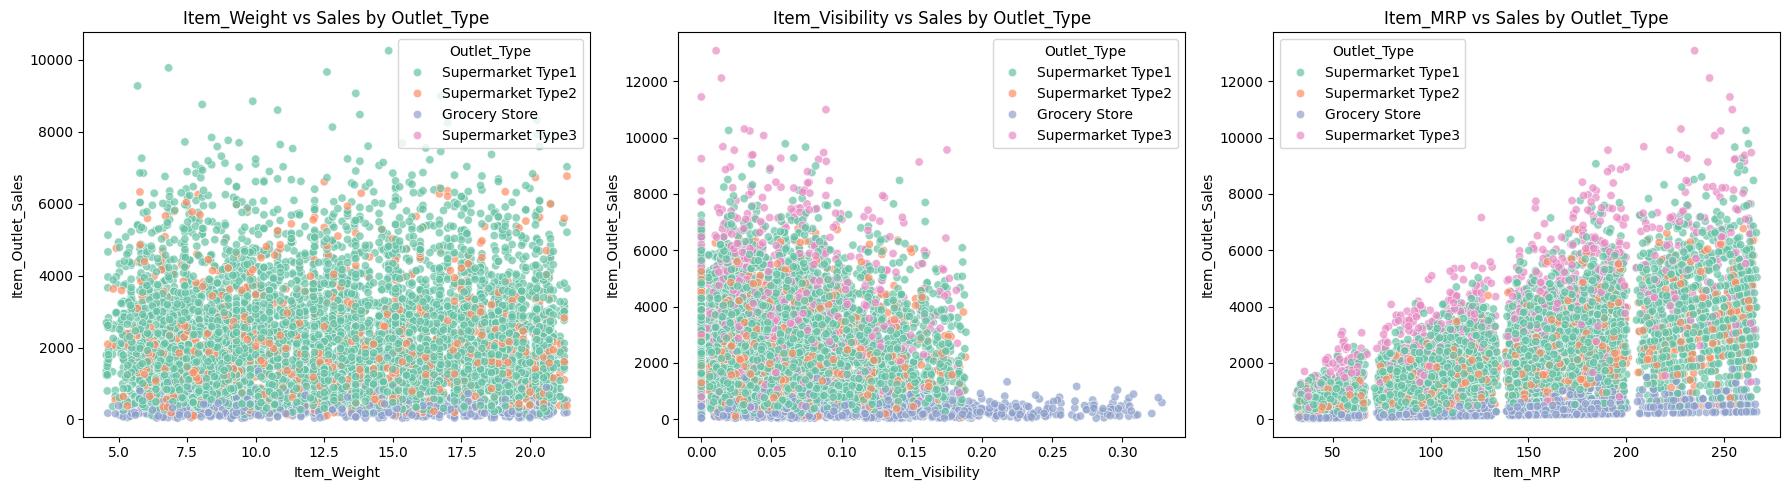

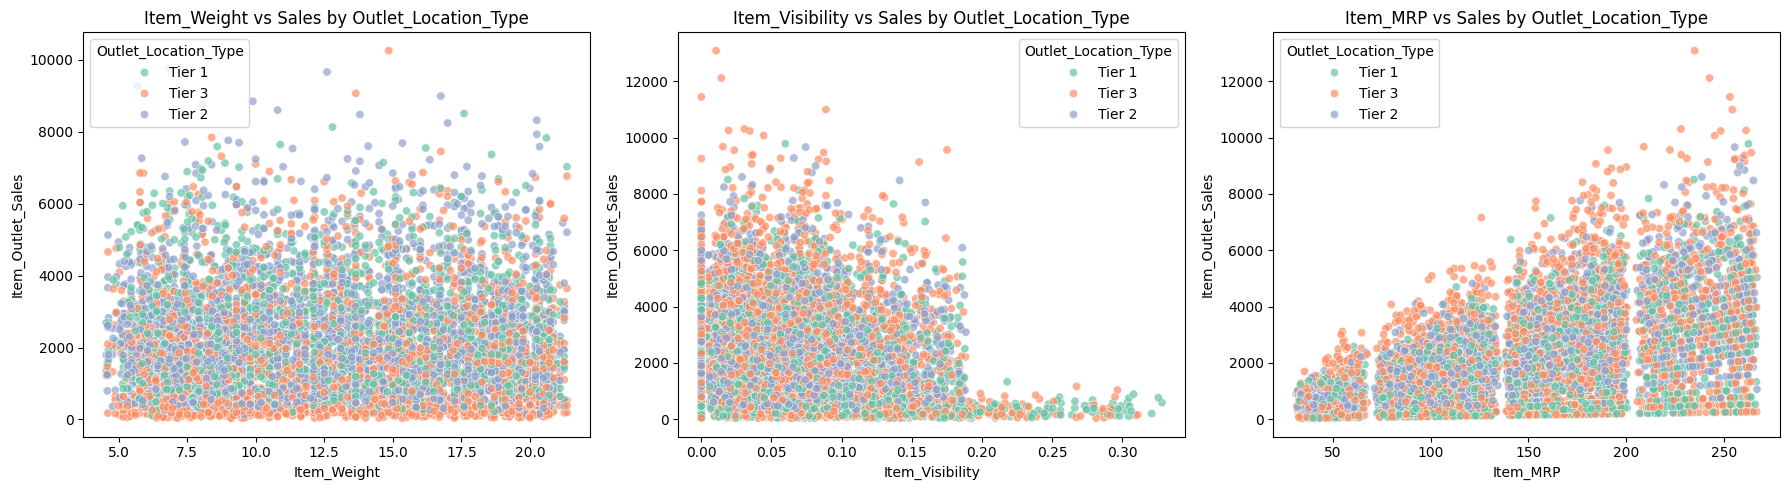

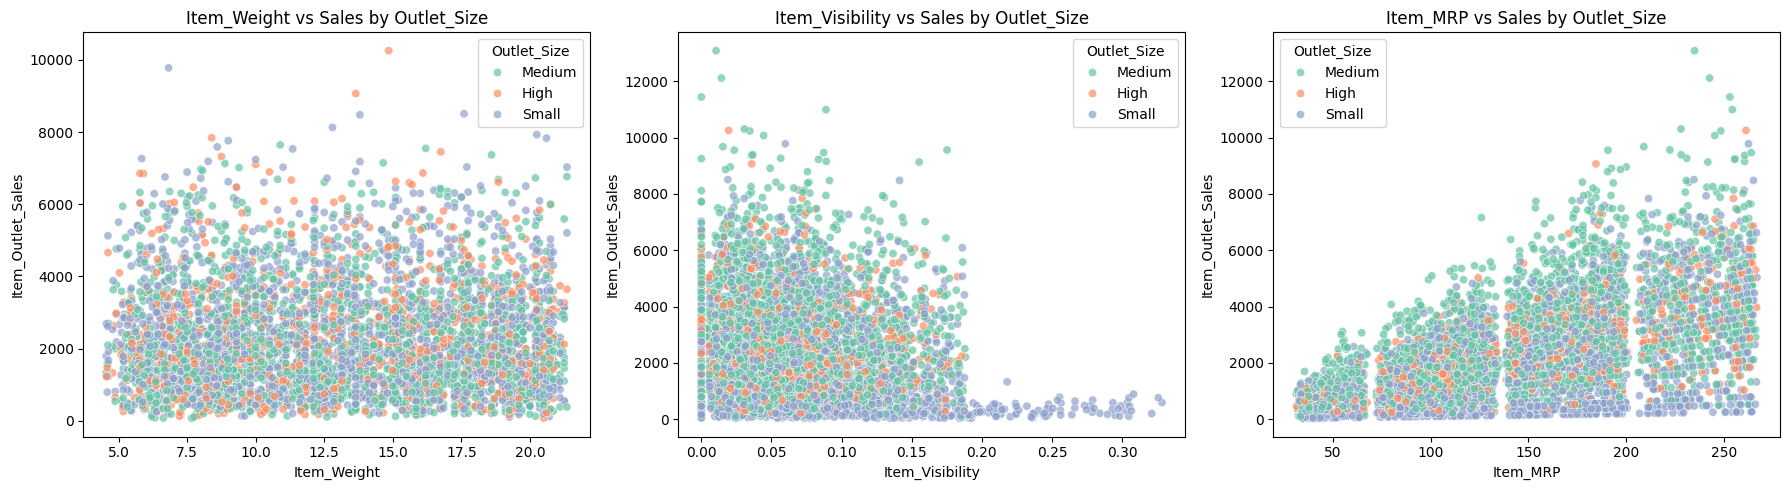

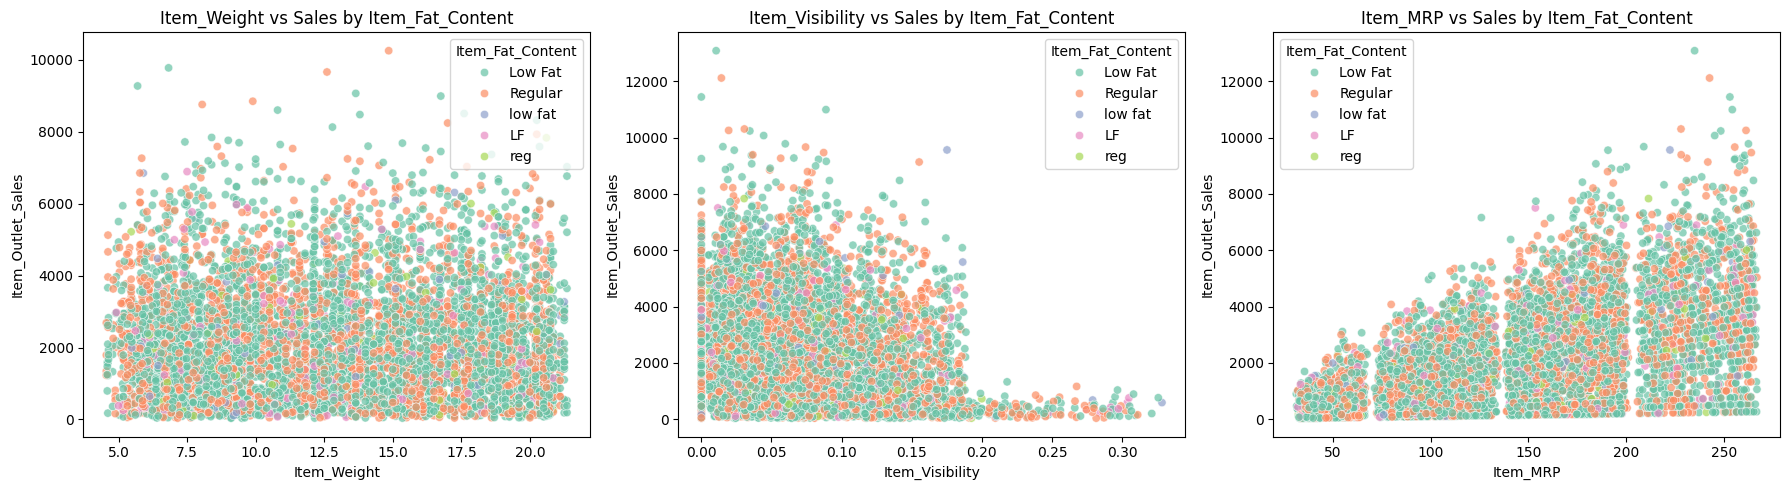

In [247]:
# Scatter plots with hue
important_categoricals = ['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content']

for cat in important_categoricals:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, num in zip(axes, ['Item_Weight', 'Item_Visibility', 'Item_MRP']):
        sns.scatterplot(x=train[num], y=train['Item_Outlet_Sales'], hue=train[cat], palette='Set2', alpha=0.7, ax=ax)
        ax.set_title(f'{num} vs Sales by {cat}')
    plt.tight_layout()
    plt.show()


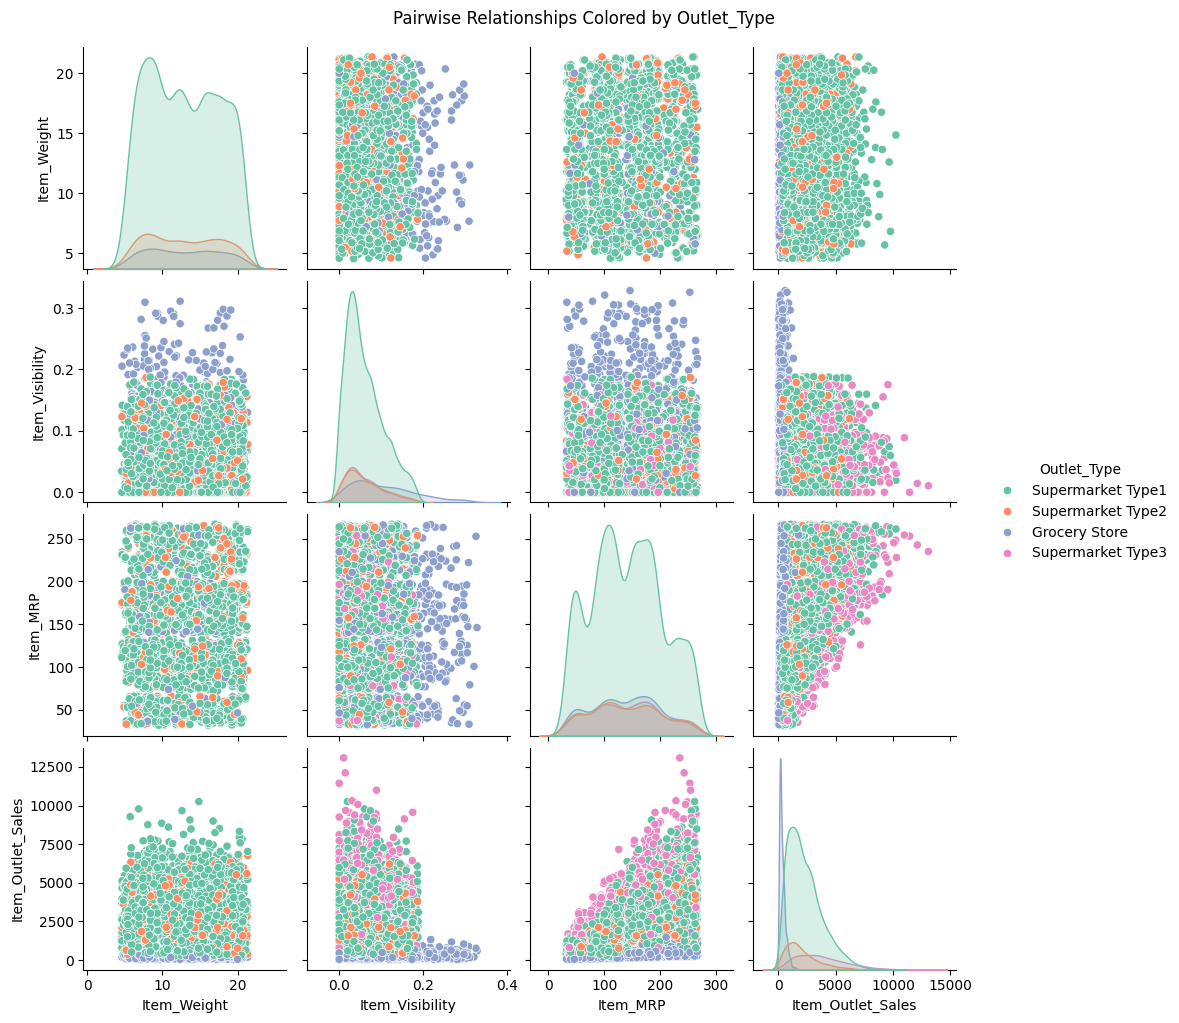

In [248]:
# Pairplot with hue for a categorical feature (e.g., Outlet_Type)
sns.pairplot(train, vars=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], hue='Outlet_Type', palette='Set2')
plt.suptitle('Pairwise Relationships Colored by Outlet_Type', y=1.02)
plt.show()

<Axes: >

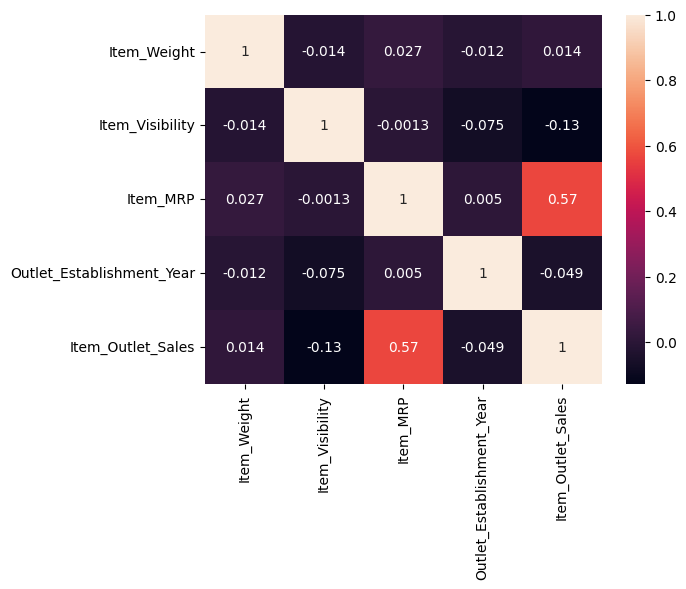

In [249]:
sns.heatmap(train.drop(['Item_Identifier','Outlet_Identifier','Outlet_Type','Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content'], axis=1).corr(), annot=True)

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

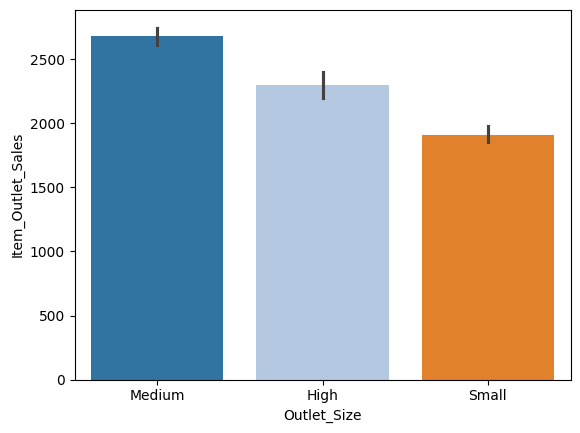

In [250]:
sns.barplot(data=train, x='Outlet_Size', y='Item_Outlet_Sales', palette='tab20')

<Axes: xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

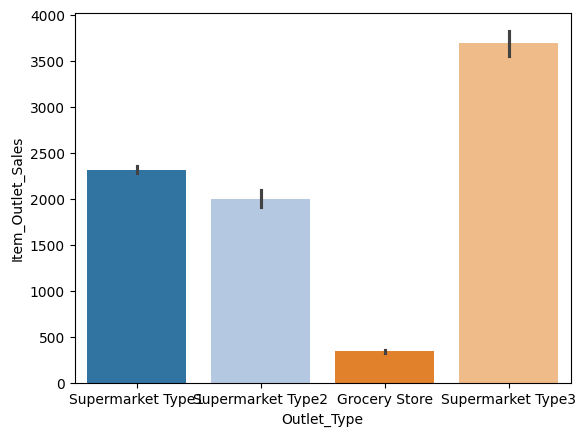

In [251]:
sns.barplot(data=train, x='Outlet_Type', y='Item_Outlet_Sales', palette='tab20')

## Missing Values Treatment

It has been seen from the exploratory data analysis that Outlet_Type and Item_Weight has null values.
We can impute missing values in the following way:
- **Item_Weight** being a numerical column and since no outliers have been seen we can replace the missing values with mean.
- **Outlet_Type** being a categorical column, we can replace the missing values with mode value.

In [252]:
# Impute Item_Weight with mean
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace=True)

# Impute Outlet_Size with mode
outlet_size_mode_train = train['Outlet_Size'].dropna().mode()[0]
outlet_size_mode_test = test['Outlet_Size'].dropna().mode()[0]

train['Outlet_Size'].fillna(outlet_size_mode_train, inplace=True)
test['Outlet_Size'].fillna(outlet_size_mode_test, inplace=True)

In [253]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Feature Engineering

### Capping of Outliers

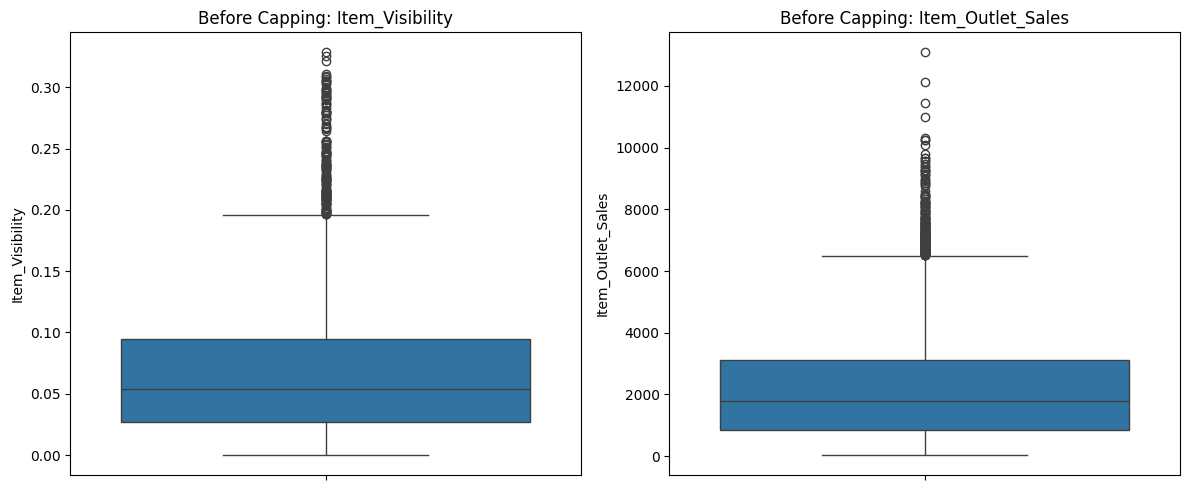

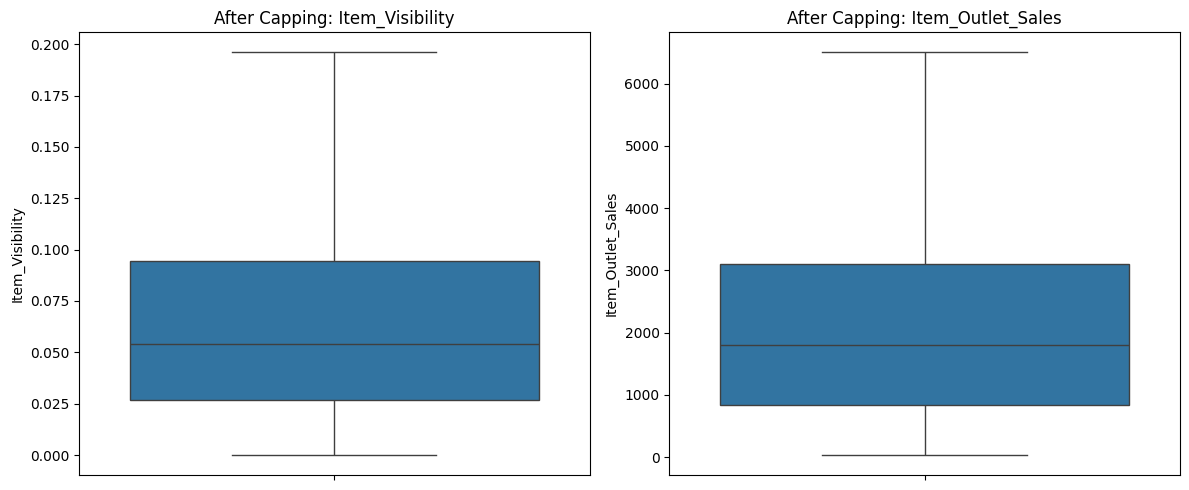

In [254]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                          np.where(df[column] > upper_bound, upper_bound, df[column]))

# Backup original columns for comparison
train_copy = train.copy()

# Before capping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=train_copy['Item_Visibility'], ax=axes[0])
axes[0].set_title('Before Capping: Item_Visibility')
sns.boxplot(y=train_copy['Item_Outlet_Sales'], ax=axes[1])
axes[1].set_title('Before Capping: Item_Outlet_Sales')
plt.tight_layout()
plt.show()

# Apply outlier capping
cap_outliers_iqr(train, 'Item_Visibility')
cap_outliers_iqr(train, 'Item_Outlet_Sales')

# After capping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=train['Item_Visibility'], ax=axes[0])
axes[0].set_title('After Capping: Item_Visibility')
sns.boxplot(y=train['Item_Outlet_Sales'], ax=axes[1])
axes[1].set_title('After Capping: Item_Outlet_Sales')
plt.tight_layout()
plt.show()

### Correcting Item_Fat_Content Column

<Axes: xlabel='Item_Fat_Content', ylabel='count'>

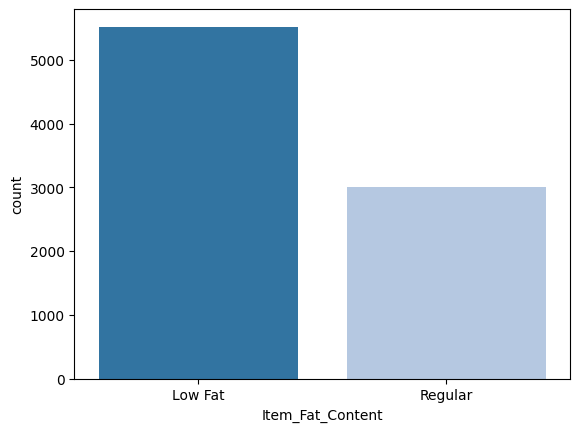

In [255]:
# Let's correct the errors in the Item_Fat_Content column

train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat':'Low Fat','low fat':"Low Fat",'LF':"Low Fat",'Regular':'Regular','reg':"Regular"})

test['Item_Fat_Content'] = test['Item_Fat_Content'].map({'Low Fat':'Low Fat','low fat' :"Low Fat",'LF':"Low Fat",'Regular':'Regular','reg':"Regular"})

# sns.countplot(x=train['Item_Fat_Content'])
sns.countplot(data=train, x='Item_Fat_Content', palette='tab20', order=train['Item_Fat_Content'].value_counts().index)


### Creating Outlet Age

In [256]:
train['Outlet_Age'] = 2013 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2013 - test['Outlet_Establishment_Year']

train = train.drop('Outlet_Establishment_Year', axis = 1)
test = test.drop('Outlet_Establishment_Year', axis = 1)

### Creating Broader category for Item _Identifier

In [257]:
# Extract broad category from Item_Identifier
train['Item_Category'] = train['Item_Identifier'].apply(lambda x: x[:2])
train['Item_Category'] = train['Item_Category'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

test['Item_Category'] = test['Item_Identifier'].apply(lambda x: x[:2])
test['Item_Category'] = test['Item_Category'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

In [258]:
# Mark Non-Consumables and set Fat_Content to 'Non-Edible'
train.loc[train['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
test.loc[test['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

<Axes: xlabel='Item_Category', ylabel='count'>

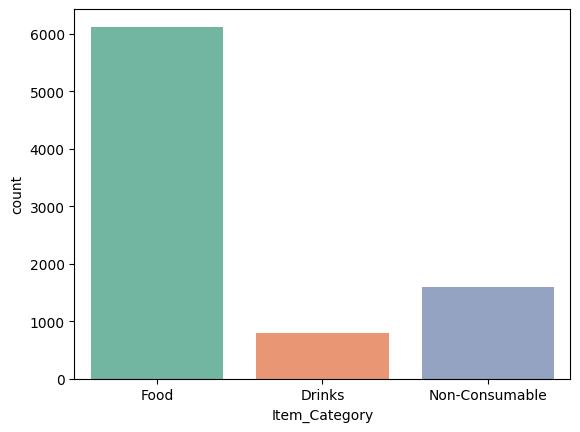

In [259]:
sns.countplot(x=train['Item_Category'], palette='Set2')

### Label Encoding

In [260]:
test.isnull().sum()

Item_Identifier         0
Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Outlet_Age              0
Item_Category           0
dtype: int64

In [261]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small'  : 1, 'Medium' : 2, 'High'   : 3}).astype(int)

test['Outlet_Size'] = test['Outlet_Size'].map({'Small'  : 1, 'Medium' : 2, 'High'   : 3}).astype(int)

<Axes: xlabel='Outlet_Size', ylabel='count'>

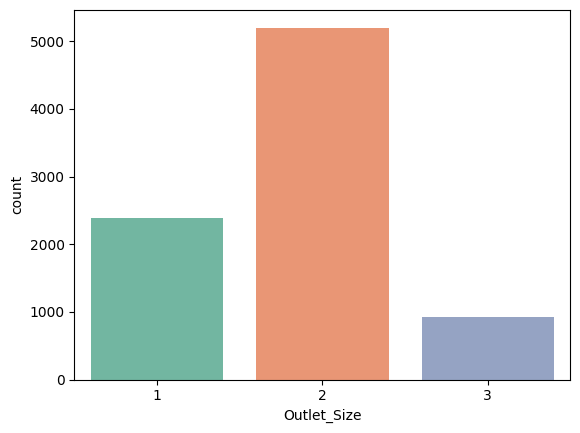

In [262]:
sns.countplot(x=train['Outlet_Size'], palette='Set2')

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

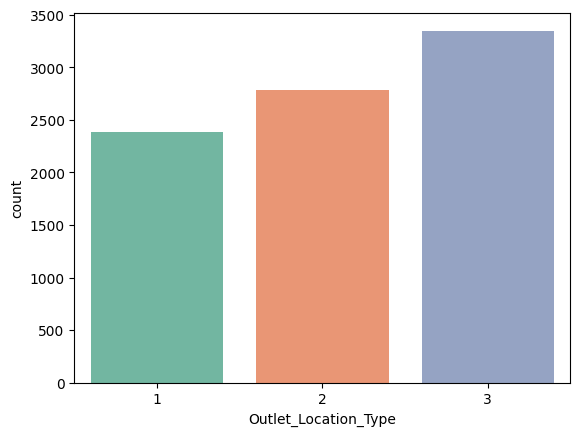

In [263]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type

train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type']  = test['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train['Outlet_Location_Type'], palette='Set2')

In [264]:
train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93       Non-Edible         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  Outlet_Size  \
0                  Dairy  249.8092            OUT049            2   
1            Soft Drinks   48.2692            OUT018            2   
2                   Meat  141.6180            OUT049            2   
3  Fruits and Vegetables  182.0950            OUT010            2   
4              Household   53.8614            OUT013            3   

   Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Outlet_Age  \
0                     1  Supermarket Type1          3735.1380          14   
1                     3  Supermarket Type2           443.4228           4   
2                     1  Supermarket Type1          2097.2700          14   
3                     3      Grocery Store           732.3800          15   
4                     3  Supermarket Type1           994.7052          26   

    Item_Category  
0            Food  
1          Drinks  
2            Food  
3            Food  
4  Non-Consumable

In [265]:
#Label Encoder for Ordinal Features

le = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size']

for feature in ordinal_features:
    train[feature] = le.fit_transform(train[feature])
    test[feature]  = le.fit_transform(test[feature])

In [266]:
# Save identifiers for final submission
test_ids = test[['Item_Identifier', 'Outlet_Identifier']].copy()

In [267]:
# One Hot Encoding for 'Item_Type', 'Item_Category', 'Outlet_Identifier' variable

train = pd.get_dummies(train, columns=['Item_Type', 'Item_Category', 'Outlet_Identifier'], drop_first=True, dtype=int)
test  = pd.get_dummies(test,  columns=['Item_Type', 'Item_Category', 'Outlet_Identifier'], drop_first=True, dtype=int)

In [268]:
train.head()

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
0           FDA15         9.30                 0         0.016047  249.8092   
1           DRC01         5.92                 2         0.019278   48.2692   
2           FDN15        17.50                 0         0.016760  141.6180   
3           FDX07        19.20                 2         0.000000  182.0950   
4           NCD19         8.93                 1         0.000000   53.8614   

   Outlet_Size  Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  \
0            1                     0            1          3735.1380   
1            1                     2            2           443.4228   
2            1                     0            1          2097.2700   
3            1                     2            0           732.3800   
4            2                     2            1           994.7052   

   Outlet_Age  ...  Item_Category_Non-Consumable  Outlet_Identifier_OUT013  \
0          14  ...                             0                         0   
1           4  ...                             0                         0   
2          14  ...                             0                         0   
3          15  ...                             0                         0   
4          26  ...                             1                         1   

   Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
0                         0                         0   
1                         0                         1   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT035  Outlet_Identifier_OUT045  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  
0                         0                         1  
1                         0                         0  
2                         0                         1  
3                         0                         0  
4                         0                         0  

[5 rows x 36 columns]

In [269]:
train.shape

(8523, 36)

## Model Building

In [270]:
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [271]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [272]:
# Step 7: Train-Test Split and Feature Scaling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
test_scaled = scaler.transform(test)

### Model Comparison

In [273]:
# Step 8: Model Comparison
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.2),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

rmse_scores = {}

for name, model in models.items():
    if name in ['LinearRegression', 'Ridge', 'Lasso']:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_valid_scaled)
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_valid_scaled, y_valid)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_valid, y_valid)

    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    r2 = r2_score(y_valid, preds)
    rmse_scores[name] = rmse

    print(f"Training score of {name}  : {train_score:.4f}")
    print(f"Test score of {name}      : {test_score:.4f}")
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} R2 Score: {r2:.4f}")
    print("="*100)

Training score of LinearRegression  : 0.5730
Test score of LinearRegression      : 0.5926
LinearRegression RMSE: 1010.0008
LinearRegression R2 Score: 0.5926
Training score of Ridge  : 0.5730
Test score of Ridge      : 0.5926
Ridge RMSE: 1009.9933
Ridge R2 Score: 0.5926
Training score of Lasso  : 0.5730
Test score of Lasso      : 0.5926
Lasso RMSE: 1009.9899
Lasso R2 Score: 0.5926
Training score of RandomForest  : 0.9387
Test score of RandomForest      : 0.5794
RandomForest RMSE: 1026.2756
RandomForest R2 Score: 0.5794
Training score of GradientBoosting  : 0.6398
Test score of GradientBoosting      : 0.6223
GradientBoosting RMSE: 972.5366
GradientBoosting R2 Score: 0.6223
Training score of XGBoost  : 0.7321
Test score of XGBoost      : 0.6042
XGBoost RMSE: 995.5560
XGBoost R2 Score: 0.6042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `for

**Observations:**
- Among Linear regression, ridge and Lasso Regression, Ridge and Lasso gives better result as it has lesser RMSE score
- Random forest seems to overfit with training score of 93% but test score of 57%
- Gradient Boosting performs the best with the lowest RMSE score of 972.53
- LightGBM also performed well with RMSE Score of 979

#### Hyper Parameter Tuning with Gradient Boosting model

In [274]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    model = GradientBoostingRegressor(random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -1.0 * score.mean()

# Create and optimize study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-05-11 15:34:57,933] A new study created in memory with name: no-name-47c4a5fe-10dc-49d5-8244-697dad60f4a8
[I 2025-05-11 15:35:05,930] Trial 1 finished with value: 1102.5412905880157 and parameters: {'n_estimators': 376, 'learning_rate': 0.047048151359376865, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.9820753759252334, 'max_features': 'sqrt'}. Best is trial 1 with value: 1102.5412905880157.
[I 2025-05-11 15:35:11,384] Trial 0 finished with value: 1187.6935071310395 and parameters: {'n_estimators': 430, 'learning_rate': 0.2579875249679746, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.6479371346133183, 'max_features': 'log2'}. Best is trial 1 with value: 1102.5412905880157.
[I 2025-05-11 15:35:33,269] Trial 2 finished with value: 1104.488398051029 and parameters: {'n_estimators': 142, 'learning_rate': 0.18349191330563602, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.5035990781929

Best hyperparameters: {'n_estimators': 266, 'learning_rate': 0.0545556086124884, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.6999951466153883, 'max_features': None}


In [275]:
# Build model with best parameters from Optuna
best_params = study.best_trial.params
optuna_gb_model = GradientBoostingRegressor(random_state=42, **best_params)
optuna_gb_model.fit(X_train, y_train)

# Evaluation
gb_preds = optuna_gb_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, gb_preds))
r2 = r2_score(y_valid, gb_preds)

print(f"Optuna-Tuned GradientBoosting RMSE: {rmse:.4f}")
print(f"Optuna-Tuned GradientBoosting R2: {r2:.4f}")


Optuna-Tuned GradientBoosting RMSE: 971.3661
Optuna-Tuned GradientBoosting R2: 0.6232


In [276]:
optuna_gb_model.fit(X, y)
final_predictions = optuna_gb_model.predict(test)
test_ids['Item_Outlet_Sales'] = final_predictions
submission = test_ids[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
submission.to_csv("bigmart_submission_optuna.csv", index=False)
print("Optuna-tuned submission file created successfully.")

Optuna-tuned submission file created successfully.


In [277]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("Best LightGBM Parameters:", study.best_trial.params)

# Retrain with best params
best_lgbm = LGBMRegressor(**study.best_trial.params, random_state=42)
best_lgbm.fit(X, y)
final_preds_lgbm = best_lgbm.predict(test)
final_preds_lgbm = np.maximum(0, final_preds_lgbm)  # Prevent negative predictions

test_ids['Item_Outlet_Sales'] = final_preds_lgbm
submission_lgbm = test_ids[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
submission_lgbm.to_csv("bigmart_submission_lightgbm_optuna.csv", index=False)
print("Submission file with Optuna-tuned LightGBM created successfully.")


[I 2025-05-11 15:38:25,815] A new study created in memory with name: no-name-7b5eabf4-4074-4e8c-8877-14129a37f60d


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-11 15:38:26,164] Trial 0 finished with value: 1073.0743402139415 and parameters: {'n_estimators': 835, 'learning_rate': 0.27049722472089893, 'max_depth': 4, 'num_leaves': 55, 'min_child_samples': 26, 'subsample': 0.6425533036080939, 'colsample_bytree': 0.9344839588851749}. Best is trial 0 with value: 1073.0743402139415.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:26,501] Trial 1 finished with value: 1011.6837717126449 and parameters: {'n_estimators': 328, 'learning_rate': 0.10514469855905709, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 87, 'subsample': 0.6840776725734141, 'colsample_bytree': 0.8934051933918581}. Best is trial 1 with value: 1011.6837717126449.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:26,643] Trial 2 finished with value: 998.387378758428 and parameters: {'n_estimators': 143, 'learning_rate': 0.12660084109123082, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 24, 'subsample': 0.9441646903644723, 'colsample_bytree': 0.9237570982998831}. Best is trial 2 with value: 998.387378758428.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-11 15:38:26,842] Trial 3 finished with value: 969.4751374067138 and parameters: {'n_estimators': 206, 'learning_rate': 0.04882205686769144, 'max_depth': 6, 'num_leaves': 135, 'min_child_samples': 56, 'subsample': 0.9801529428346092, 'colsample_bytree': 0.959488569410228}. Best is trial 3 with value: 969.4751374067138.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:27,172] Trial 4 finished with value: 965.5319337084519 and parameters: {'n_estimators': 893, 'learning_rate': 0.01417318671429987, 'max_depth': 3, 'num_leaves': 29, 'min_child_samples': 38, 'subsample': 0.9039110162931567, 'colsample_bytree': 0.9971365975126334}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:27,499] Trial 5 finished with value: 1057.794704116178 and parameters: {'n_estimators': 438, 'learning_rate': 0.2487303228237383, 'max_depth': 7, 'num_leaves': 150, 'min_child_samples': 80, 'subsample': 0.7770420729300136, 'colsample_bytree': 0.7547975487403569}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:28,956] Trial 6 finished with value: 1127.5976479947137 and parameters: {'n_estimators': 789, 'learning_rate': 0.11097508654612018, 'max_depth': 11, 'num_leaves': 100, 'min_child_samples': 6, 'subsample': 0.534214382759437, 'colsample_bytree': 0.8268104303269925}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:29,893] Trial 7 finished with value: 1165.2400600620913 and parameters: {'n_estimators': 911, 'learning_rate': 0.2899580792831878, 'max_depth': 11, 'num_leaves': 94, 'min_child_samples': 85, 'subsample': 0.8958432351534888, 'colsample_bytree': 0.6966905616331298}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-11 15:38:30,153] Trial 8 finished with value: 1055.0522363503255 and parameters: {'n_estimators': 260, 'learning_rate': 0.23665316408981693, 'max_depth': 10, 'num_leaves': 84, 'min_child_samples': 83, 'subsample': 0.6692373445108012, 'colsample_bytree': 0.9178942120759348}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:30,395] Trial 9 finished with value: 995.7430680614468 and parameters: {'n_estimators': 595, 'learning_rate': 0.13400200713467167, 'max_depth': 4, 'num_leaves': 42, 'min_child_samples': 76, 'subsample': 0.6472365850593282, 'colsample_bytree': 0.7358628339951927}. Best is trial 4 with value: 965.5319337084519.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:30,746] Trial 10 finished with value: 962.8116727978178 and parameters: {'n_estimators': 655, 'learning_rate': 0.011922162825161906, 'max_depth': 3, 'num_leaves': 31, 'min_child_samples': 52, 'subsample': 0.8429757758798155, 'colsample_bytree': 0.5372413211075846}. Best is trial 10 with value: 962.8116727978178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:31,025] Trial 11 finished with value: 962.8848705504375 and parameters: {'n_estimators': 658, 'learning_rate': 0.01198599959232167, 'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 50, 'subsample': 0.8478093803824553, 'colsample_bytree': 0.5050341120243033}. Best is trial 10 with value: 962.8116727978178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:31,473] Trial 12 finished with value: 981.4144744188757 and parameters: {'n_estimators': 627, 'learning_rate': 0.057584816312538326, 'max_depth': 5, 'num_leaves': 27, 'min_child_samples': 55, 'subsample': 0.8209405885283153, 'colsample_bytree': 0.5022680503500566}. Best is trial 10 with value: 962.8116727978178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:31,743] Trial 13 finished with value: 999.1481882201522 and parameters: {'n_estimators': 700, 'learning_rate': 0.19387675957089665, 'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 43, 'subsample': 0.8496366693736912, 'colsample_bytree': 0.539314868786311}. Best is trial 10 with value: 962.8116727978178.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:32,107] Trial 14 finished with value: 961.6515830873648 and parameters: {'n_estimators': 423, 'learning_rate': 0.012674354476340084, 'max_depth': 5, 'num_leaves': 73, 'min_child_samples': 64, 'subsample': 0.7581619322575173, 'colsample_bytree': 0.5983902246010955}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:32,403] Trial 15 finished with value: 973.1812868169139 and parameters: {'n_estimators': 467, 'learning_rate': 0.05274049186790791, 'max_depth': 5, 'num_leaves': 73, 'min_child_samples': 70, 'subsample': 0.7358938961199198, 'colsample_bytree': 0.6022662179461052}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:32,873] Trial 16 finished with value: 1002.0269401999325 and parameters: {'n_estimators': 469, 'learning_rate': 0.0827339391705084, 'max_depth': 8, 'num_leaves': 114, 'min_child_samples': 67, 'subsample': 0.7553252076841511, 'colsample_bytree': 0.6174487070374475}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:33,357] Trial 17 finished with value: 1032.2483733959184 and parameters: {'n_estimators': 995, 'learning_rate': 0.17375354123264736, 'max_depth': 5, 'num_leaves': 71, 'min_child_samples': 97, 'subsample': 0.5620546054117341, 'colsample_bytree': 0.607368388824097}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:33,733] Trial 18 finished with value: 974.3881741761707 and parameters: {'n_estimators': 352, 'learning_rate': 0.03310907880905989, 'max_depth': 8, 'num_leaves': 116, 'min_child_samples': 65, 'subsample': 0.7998947093056813, 'colsample_bytree': 0.6594442828726023}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:34,163] Trial 19 finished with value: 1005.0591033537867 and parameters: {'n_estimators': 528, 'learning_rate': 0.08024981889914064, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 29, 'subsample': 0.7245066918108996, 'colsample_bytree': 0.5612155192401332}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:34,373] Trial 20 finished with value: 999.7301732612913 and parameters: {'n_estimators': 379, 'learning_rate': 0.21059568158919906, 'max_depth': 4, 'num_leaves': 77, 'min_child_samples': 59, 'subsample': 0.5897661450799612, 'colsample_bytree': 0.6630746293682995}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:34,660] Trial 21 finished with value: 963.6828569431266 and parameters: {'n_estimators': 700, 'learning_rate': 0.018471804761562204, 'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 47, 'subsample': 0.8634521391278357, 'colsample_bytree': 0.5025168070183323}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:34,920] Trial 22 finished with value: 963.3356154219038 and parameters: {'n_estimators': 676, 'learning_rate': 0.011058606703938404, 'max_depth': 3, 'num_leaves': 37, 'min_child_samples': 35, 'subsample': 0.8225519964819927, 'colsample_bytree': 0.5756576562245186}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:35,311] Trial 23 finished with value: 986.9958088549746 and parameters: {'n_estimators': 755, 'learning_rate': 0.0771101968387862, 'max_depth': 4, 'num_leaves': 55, 'min_child_samples': 52, 'subsample': 0.8909511970028674, 'colsample_bytree': 0.5369877872702897}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:35,798] Trial 24 finished with value: 978.4372233008193 and parameters: {'n_estimators': 547, 'learning_rate': 0.035915583852968155, 'max_depth': 6, 'num_leaves': 34, 'min_child_samples': 47, 'subsample': 0.944859387143903, 'colsample_bytree': 0.6414838739120808}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:36,105] Trial 25 finished with value: 980.2717058000708 and parameters: {'n_estimators': 631, 'learning_rate': 0.06716168660524034, 'max_depth': 4, 'num_leaves': 62, 'min_child_samples': 61, 'subsample': 0.789505205923381, 'colsample_bytree': 0.5693941292622661}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:36,438] Trial 26 finished with value: 967.8380572882234 and parameters: {'n_estimators': 544, 'learning_rate': 0.03325800189575061, 'max_depth': 5, 'num_leaves': 51, 'min_child_samples': 71, 'subsample': 0.7087825942595628, 'colsample_bytree': 0.5360317931692515}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:36,758] Trial 27 finished with value: 994.2628029440108 and parameters: {'n_estimators': 765, 'learning_rate': 0.09792682779466029, 'max_depth': 3, 'num_leaves': 98, 'min_child_samples': 15, 'subsample': 0.8484621310655981, 'colsample_bytree': 0.6956445405087184}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:37,004] Trial 28 finished with value: 967.9662880298442 and parameters: {'n_estimators': 480, 'learning_rate': 0.0357404224127943, 'max_depth': 4, 'num_leaves': 36, 'min_child_samples': 50, 'subsample': 0.7567243814975988, 'colsample_bytree': 0.5045884061137053}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:37,428] Trial 29 finished with value: 1016.5468028349658 and parameters: {'n_estimators': 838, 'learning_rate': 0.15107241661380028, 'max_depth': 4, 'num_leaves': 62, 'min_child_samples': 42, 'subsample': 0.9326052089386047, 'colsample_bytree': 0.8154241252859011}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:37,646] Trial 30 finished with value: 963.4362817719715 and parameters: {'n_estimators': 394, 'learning_rate': 0.013945333294103435, 'max_depth': 3, 'num_leaves': 109, 'min_child_samples': 34, 'subsample': 0.6205763563247788, 'colsample_bytree': 0.6054653918704825}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:37,981] Trial 31 finished with value: 963.2023405164834 and parameters: {'n_estimators': 680, 'learning_rate': 0.01103101277320849, 'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 33, 'subsample': 0.8253280013916691, 'colsample_bytree': 0.5665771256791625}. Best is trial 14 with value: 961.6515830873648.
[I 2025-05-11 15:38:38,226] Trial 32 finished with value: 972.718043473059 and parameters: {'n_estimators': 604, 'learning_rate': 0.044865039507509225, 'max_depth': 3, 'num_leaves': 21, 'min_child_samples': 20, 'subsample': 0.8205105590411481, 'colsample_bytree': 0.5713971608545825}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:38,711] Trial 33 finished with value: 972.8050327033714 and parameters: {'n_estimators': 645, 'learning_rate': 0.02424542325628963, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 31, 'subsample': 0.8723939182613798, 'colsample_bytree': 0.5392845408775375}. Best is trial 14 with value: 961.6515830873648.
[I 2025-05-11 15:38:38,868] Trial 34 finished with value: 966.6686856145409 and parameters: {'n_estimators': 299, 'learning_rate': 0.05941324986155041, 'max_depth': 4, 'num_leaves': 48, 'min_child_samples': 62, 'subsample': 0.6903105347793208, 'colsample_bytree': 0.6381544414037195}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:39,708] Trial 35 finished with value: 1050.3985418019565 and parameters: {'n_estimators': 745, 'learning_rate': 0.09541906237082702, 'max_depth': 9, 'num_leaves': 41, 'min_child_samples': 40, 'subsample': 0.9944958847629348, 'colsample_bytree': 0.5807208950421197}. Best is trial 14 with value: 961.6515830873648.
[I 2025-05-11 15:38:39,864] Trial 36 finished with value: 1065.1086033185882 and parameters: {'n_estimators': 135, 'learning_rate': 0.011881162927478338, 'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 55, 'subsample': 0.7665931650234057, 'colsample_bytree': 0.53097289885391}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:40,277] Trial 37 finished with value: 997.4755105078589 and parameters: {'n_estimators': 577, 'learning_rate': 0.044996720116266556, 'max_depth': 12, 'num_leaves': 21, 'min_child_samples': 21, 'subsample': 0.920491885951616, 'colsample_bytree': 0.8254836953653139}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:41,079] Trial 38 finished with value: 1022.4516880785042 and parameters: {'n_estimators': 869, 'learning_rate': 0.06909483958449227, 'max_depth': 7, 'num_leaves': 129, 'min_child_samples': 46, 'subsample': 0.806577223597392, 'colsample_bytree': 0.6856811533974168}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-11 15:38:41,365] Trial 39 finished with value: 963.8073572414593 and parameters: {'n_estimators': 681, 'learning_rate': 0.02605081258804655, 'max_depth': 3, 'num_leaves': 55, 'min_child_samples': 75, 'subsample': 0.8421741160591038, 'colsample_bytree': 0.7601983271711719}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 32
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:41,755] Trial 40 finished with value: 1011.0962096568495 and parameters: {'n_estimators': 798, 'learning_rate': 0.11995662058335226, 'max_depth': 5, 'num_leaves': 84, 'min_child_samples': 92, 'subsample': 0.9601656473900693, 'colsample_bytree': 0.7312807330670654}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:42,012] Trial 41 finished with value: 963.2339148624425 and parameters: {'n_estimators': 686, 'learning_rate': 0.013155294231147568, 'max_depth': 3, 'num_leaves': 37, 'min_child_samples': 36, 'subsample': 0.8291378051304497, 'colsample_bytree': 0.5866667315361686}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:42,305] Trial 42 finished with value: 974.8727759287812 and parameters: {'n_estimators': 739, 'learning_rate': 0.04413188551007728, 'max_depth': 3, 'num_leaves': 34, 'min_child_samples': 25, 'subsample': 0.8813324119392613, 'colsample_bytree': 0.5920612520759599}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 34
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:42,657] Trial 43 finished with value: 962.7325226718287 and parameters: {'n_estimators': 667, 'learning_rate': 0.010206597637468064, 'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 39, 'subsample': 0.7739314835019262, 'colsample_bytree': 0.5563454755864761}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:42,887] Trial 44 finished with value: 966.8578459480152 and parameters: {'n_estimators': 507, 'learning_rate': 0.03217708647344995, 'max_depth': 4, 'num_leaves': 26, 'min_child_samples': 51, 'subsample': 0.7384306682012568, 'colsample_bytree': 0.5544005173752401}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:43,160] Trial 45 finished with value: 977.2204407785584 and parameters: {'n_estimators': 590, 'learning_rate': 0.05639366279876404, 'max_depth': 4, 'num_leaves': 29, 'min_child_samples': 43, 'subsample': 0.7917649876145353, 'colsample_bytree': 0.5226469130072929}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:43,396] Trial 46 finished with value: 962.4145705844228 and parameters: {'n_estimators': 238, 'learning_rate': 0.023048683748217773, 'max_depth': 5, 'num_leaves': 150, 'min_child_samples': 58, 'subsample': 0.7751881760482996, 'colsample_bytree': 0.629204525934902}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:43,586] Trial 47 finished with value: 1027.3221840521005 and parameters: {'n_estimators': 246, 'learning_rate': 0.2974463863161914, 'max_depth': 6, 'num_leaves': 138, 'min_child_samples': 58, 'subsample': 0.7818784184038262, 'colsample_bytree': 0.6279504778527368}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 33
[LightGBM] [Info] Start training from score 2176.113255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-05-11 15:38:43,730] Trial 48 finished with value: 1000.954210362185 and parameters: {'n_estimators': 103, 'learning_rate': 0.026180521855883314, 'max_depth': 5, 'num_leaves': 92, 'min_child_samples': 67, 'subsample': 0.6903854088537844, 'colsample_bytree': 0.5230548357732783}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-11 15:38:43,899] Trial 49 finished with value: 1009.2766377755477 and parameters: {'n_estimators': 202, 'learning_rate': 0.25452949403214736, 'max_depth': 6, 'num_leaves': 144, 'min_child_samples': 79, 'subsample': 0.7263567832501941, 'colsample_bytree': 0.6602272785670278}. Best is trial 14 with value: 961.6515830873648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [278]:
# Evaluate tuned model on validation set
lgbm_valid_preds = best_lgbm.predict(X_valid)
lgbm_rmse = np.sqrt(mean_squared_error(y_valid, lgbm_valid_preds))
lgbm_r2 = r2_score(y_valid, lgbm_valid_preds)

print(f"Optuna-Tuned LightGBM Validation RMSE: {lgbm_rmse:.4f}")
print(f"Optuna-Tuned LightGBM Validation R2: {lgbm_r2:.4f}")

Optuna-Tuned LightGBM Validation RMSE: 931.6643
Optuna-Tuned LightGBM Validation R2: 0.6534
